#  Práctica Obligatoria - Parte II - MLP

***<p style="text-align:center;">Aprendizaje Automático II</p>***
***<p style="text-align:center;">MLPs</p>***

En esta parte, entrenarás varias redes MLPs y analizarás sus resultados en el dataset GTS. 


### Evaluación - 3/10 puntos

Puntuación de cada parte sobre el total de la práctica:
- **[Ejercicio 1]** 0.25 puntos.
- **[Ejercicio 2]** 0.25 puntos.
- **[Ejercicio 3]** 0.5 puntos.
- **[Ejercicio 4]** 1 punto.
- **[Ejercicio 5]** 0.5 puntos.
- **[Ejercicio 6]** 0.5 puntos.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms

from gts_dataset import GTS


## Carga German Traffic Signs (GTS) dataset

Carga GTS en sus tres partes, como en el notebook anterior.

In [3]:
# Definir las transformaciones y conversión a tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = GTS(csv_file='train.csv', root_dir='./data', transform=transform)
valid_dataset = GTS(csv_file='valid.csv', root_dir='./data', transform=transform)
test_dataset = GTS(csv_file='test.csv', root_dir='./data', transform=transform)

### **[Ejercicio 1]** Crear una `MLP` con una única capa oculta

Las imágenes son de $25x25$ pixeles con $3$ canales (RGB), a si que eso nos da una entrada de $1875$ valores $(25x25x3)$. La salida debe de ser de 43 (una neurona por cada clase de señal).

In [5]:
################ COMPLETAR #################
# Red neuronal MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        # aplanamos la imagen (25x25x3) a un vector de 1875 elementos
        self.flatten = nn.Flatten()

        # capa de entrada a capa oculta
        self.f1 = nn.Linear(input_size, hidden_size)

        # funcion de activacion (relu)
        self.relu = nn.ReLU()

        # capa oculta a capa de salida
        self.f2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.flatten(x)
        x = self.f1(x)
        x = self.relu(x)
        x = self.f2(x)
        return x
############## Fin COMPLETAR ###############

### **[Ejercicio 2]** Crea una función que cuente el número de parámetros entrenables de un modelo

In [ ]:
################ COMPLETAR #################
def count_trainable_params(model: nn.Module) -> int:
    """
    Cuenta el número de parámetros entrenables en un modelo PyTorch.

    Args:
        model (nn.Module): El modelo de PyTorch.

    Returns:
        int: El número total de parámetros entrenables.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
############## Fin COMPLETAR ###############

Instancia el modelo `MLP` que has creado antes y configúralo para que no tenga más de **200.000** parámetros:

Para que el modelo sea eficiente y no sobrepase los 200.000 parametros debemos de elegir bien el tamaño de la capa oculta.

Si usamos 100 neuronas ocultas:

- Pesoso de entrada ($1875 \times 100$) + Sesgos ($100$) = $187600$
- Pesos de salida ($100 \times 43$) + Sesgos($43$) = $4343$
- TOTAL = $191943 < 200000$


In [7]:
################ COMPLETAR #################
input_size = 25 * 25 * 3
hidden_size = 100
output_size = 43

#creamos el modelo
model = MLP(input_size, hidden_size, output_size)

trainable_params = count_trainable_params(model)
print(f"Número de parámetros entrenables: {trainable_params}")
############## Fin COMPLETAR ###############

Número de parámetros entrenables: 191943


### **[Ejercicio 3]** Crea las funciones de apoyo para el entrenamiento

Durante el entrenamiento, debes guardas las pérdidas de entrenamiento y validación para, posteriormente, graficarlas.

Para ello, guárdalas en un archivo `train_loss_mlp.csv` y otro `valid_loss_mlp.csv`.

Haz lo mismo para los *accuracies* `train_accuracy_mlp.csv` y `valid_accuracy_mlp.csv`.

In [9]:
################ COMPLETAR #################
# Función de entrenamiento
def train(model, train_loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass y optimización
        optimizer.zero_grad() #limpiamos gradientes anteriores
        loss.backward() #calculamos cuanto hay que corregir cada peso
        optimizer.step() #aplicamos la correcion

        running_loss += loss.item()

        # Calcular la precisión
        _, predicted = torch.max(outputs.data, 1) #obtenemos la clase con mayor probabilidad
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy
############## Fin COMPLETAR ###############

################ COMPLETAR #################
# Función de evaluación
def evaluate(model, val_loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad(): #para desactivar el cálculo de gradientes
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item()

            # Calcular la precisión
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = correct / total
    return avg_loss, accuracy
############## Fin COMPLETAR ###############

################ COMPLETAR #################
# Función para entrenar y evaluar, guardando las pérdidas y precisiones en archivos CSV
def train_and_evaluate(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=10, test_loader=None, name='None'):
    train_losses = []
    val_losses = []
    train_accuracies = []  # Lista para almacenar las precisiones de entrenamiento
    val_accuracies = []  # Lista para almacenar las precisiones de validación

    # Ciclo de entrenamiento
    for epoch in range(num_epochs):
        # Entrenamiento
        train_loss, train_accuracy = train(model, train_loader, loss_fn, optimizer, device) # COMPLETAR
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluación en el conjunto de validación
        val_loss, val_accuracy = evaluate(model, val_loader, loss_fn, device)# COMPLETAR
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Imprimir pérdidas y precisión
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Guardar pérdidas y precisión en archivos CSV
    train_loss_df = pd.DataFrame({'Epoch': range(1, num_epochs+1), 'Train Loss': train_losses, 'Train Accuracy': train_accuracies})
    val_loss_df = pd.DataFrame({'Epoch': range(1, num_epochs+1), 'Validation Loss': val_losses, 'Validation Accuracy': val_accuracies})
    
    train_loss_df.to_csv(f'train_loss_{name}.csv', index=False)
    val_loss_df.to_csv(f'valid_loss_{name}.csv', index=False)

    # Evaluación en el conjunto de test (si se proporciona)
    if test_loader is not None:
        test_loss, test_accuracy =  evaluate(model, val_loader, loss_fn, device) # COMPLETAR
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        
        # Guardar la precisión de test en un archivo CSV
        test_accuracy_df = pd.DataFrame({'Test Accuracy': [test_accuracy]})
        test_accuracy_df.to_csv(f'test_accuracy_{name}.csv', index=False)

    # Guardar las precisiones de entrenamiento y validación en archivos CSV
    train_accuracy_df = pd.DataFrame({'Epoch': range(1, num_epochs+1), 'Train Accuracy': train_accuracies})
    val_accuracy_df = pd.DataFrame({'Epoch': range(1, num_epochs+1), 'Validation Accuracy': val_accuracies})

    train_accuracy_df.to_csv(f'train_accuracy_{name}.csv', index=False)
    val_accuracy_df.to_csv(f'valid_accuracy_{name}.csv', index=False)

    return train_loss_df, val_loss_df, test_loss, test_accuracy
############## Fin COMPLETAR ###############


### **[Ejercicio 4]** Entrena el modelo solo 10 épocas.

Puedes hacer uso de la `gpu`, aunque no es necesario. De manera orientativa, 10 épocas en `cpu` deberían tardar menos de 90 segundos.

Para ellos, crea los dataloaders e instancia el modelo sin sobrepasar los 200.000 parámetros.

Usa una función de pérdida apropiada y el optimizador que consideres.


In [13]:
device = 'cpu'
batch_size = 16

################ COMPLETAR #################
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

model = MLP(input_size=25*25*3, hidden_size=100, output_size=43).to(device)

loss_fn = nn.CrossEntropyLoss() #para clasificacion multiclase
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) #para poder ajustar automaticament el lr
num_epochs = 10
# Entrenar y evaluar el modelo

train_loss_df, val_loss_df, test_loss, test_accuracy = train_and_evaluate(model, train_loader, valid_loader, loss_fn, optimizer, device, num_epochs, test_loader, name="mlp1") # COMPLETAR

############## Fin COMPLETAR ###############

Epoch [1/10], Train Loss: 2.3254, Train Accuracy: 0.4006, Validation Loss: 1.6313, Validation Accuracy: 0.5584
Epoch [2/10], Train Loss: 1.2579, Train Accuracy: 0.6696, Validation Loss: 1.0675, Validation Accuracy: 0.7268
Epoch [3/10], Train Loss: 0.8876, Train Accuracy: 0.7717, Validation Loss: 0.8148, Validation Accuracy: 0.7843
Epoch [4/10], Train Loss: 0.7152, Train Accuracy: 0.8143, Validation Loss: 0.6946, Validation Accuracy: 0.8238
Epoch [5/10], Train Loss: 0.6069, Train Accuracy: 0.8462, Validation Loss: 0.7444, Validation Accuracy: 0.7742
Epoch [6/10], Train Loss: 0.5300, Train Accuracy: 0.8647, Validation Loss: 0.5583, Validation Accuracy: 0.8584
Epoch [7/10], Train Loss: 0.4829, Train Accuracy: 0.8771, Validation Loss: 0.6204, Validation Accuracy: 0.8342
Epoch [8/10], Train Loss: 0.4419, Train Accuracy: 0.8872, Validation Loss: 0.4653, Validation Accuracy: 0.8838
Epoch [9/10], Train Loss: 0.4206, Train Accuracy: 0.8921, Validation Loss: 0.4302, Validation Accuracy: 0.8920
E

Guarda el modelo pytorch con ayuda de las siguientes funciones, lo necesitarás más adelante.

Guárdalo con el nombre `mlp.pth`.

In [24]:
def save_full_model(model, file_name):
    """
    Guarda el modelo completo, incluyendo la arquitectura y los pesos.

    Args:
        model: El modelo de PyTorch a guardar.
        file_name: El nombre del archivo donde se guardará el modelo.
    """
    torch.save(model, file_name)
    print(f"Modelo completo guardado como {file_name}")


def load_full_model(file_name):
    
    """
    Carga el modelo completo desde un archivo guardado.

    Args:
        file_name: El nombre del archivo del modelo guardado.

    Returns:
        model: El modelo cargado.
    """
    model = torch.load(file_name, weights_only=False)
    print(f"Modelo cargado desde {file_name}")
    return model


################ COMPLETAR #################
save_full_model(model, 'mlp.pth')
############## Fin COMPLETAR ###############

Modelo completo guardado como mlp.pth


### **[Ejercicio 5]** Carga los datos de 'loss' y 'accuracy' que has generado y pinta las gráficas

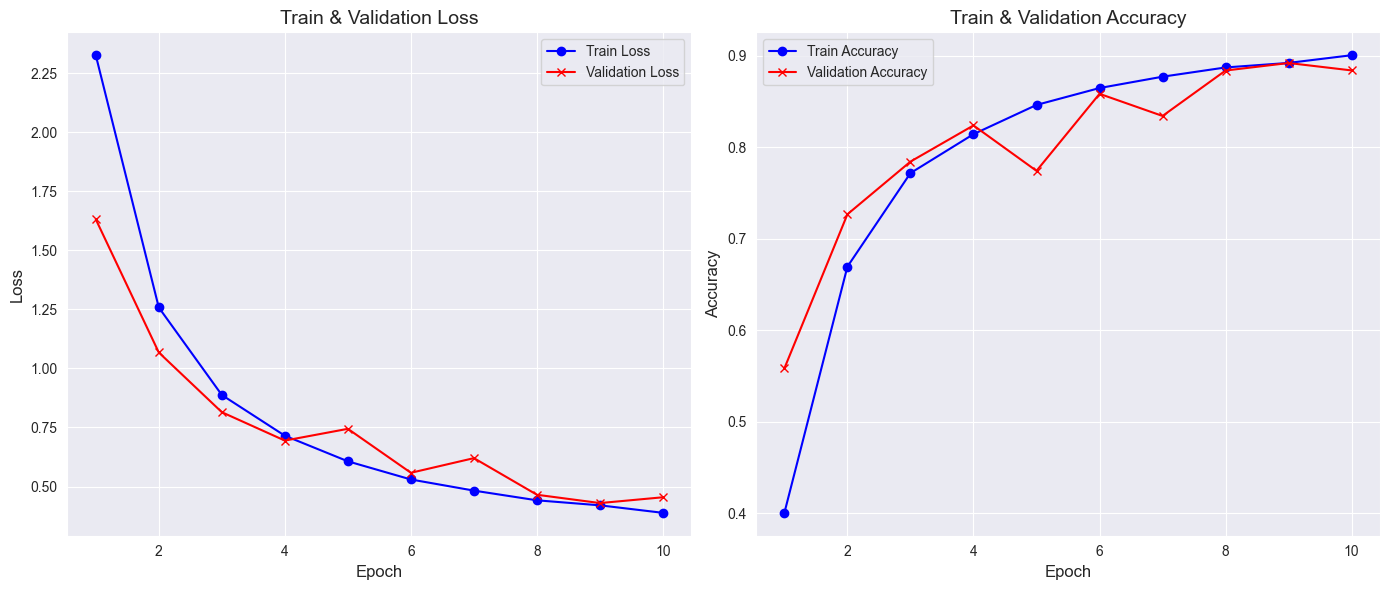

In [25]:
################ COMPLETAR #################

def plot_loss_accuracy(train_loss_file, valid_loss_file, train_accuracy_file, valid_accuracy_file):
    # Leer los archivos CSV con los datos
    train_loss_df = pd.read_csv(train_loss_file)
    valid_loss_df = pd.read_csv(valid_loss_file)
    train_accuracy_df = pd.read_csv(train_accuracy_file)
    valid_accuracy_df = pd.read_csv(valid_accuracy_file)

    # Configuración de la figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfico de las pérdidas
    ax1.plot(train_loss_df['Epoch'], train_loss_df['Train Loss'], label='Train Loss', color='blue', linestyle='-', marker='o')
    ax1.plot(valid_loss_df['Epoch'], valid_loss_df['Validation Loss'], label='Validation Loss', color='red', linestyle='-', marker='x')
    ax1.set_title('Train & Validation Loss', fontsize=14)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()
    ax1.grid(True)

    # Gráfico de las precisiones
    ax2.plot(train_accuracy_df['Epoch'], train_accuracy_df['Train Accuracy'], label='Train Accuracy', color='blue', linestyle='-', marker='o')
    ax2.plot(valid_accuracy_df['Epoch'], valid_accuracy_df['Validation Accuracy'], label='Validation Accuracy', color='red', linestyle='-', marker='x')
    ax2.set_title('Train & Validation Accuracy', fontsize=14)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend()
    ax2.grid(True)

    # Mostrar las gráficas
    plt.tight_layout()
    plt.show()
    
############## Fin COMPLETAR ###############


# Carga los datos y muéstralos
train_loss_file = 'train_loss_mlp1.csv'
valid_loss_file = 'valid_loss_mlp1.csv'
train_accuracy_file = 'train_accuracy_mlp1.csv'
valid_accuracy_file = 'valid_accuracy_mlp1.csv'

plot_loss_accuracy(train_loss_file, valid_loss_file, train_accuracy_file, valid_accuracy_file)

El modelo alcanzó un 88% de accuracy, lo que indica una buena convergencia. Además no observamos ninguna señal de overfitting.

### **[Ejercicio 6]** Calcula la matriz de confusión y el porcentaje de error por clase

Modelo cargado desde mlp.pth


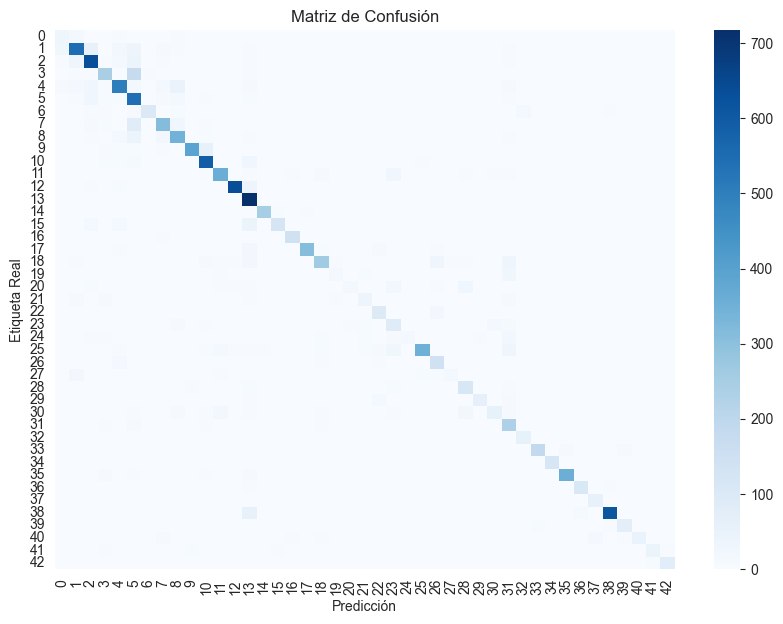

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

################ COMPLETAR #################

def plot_confusion_matrix(model, test_dataloader, device):
    """
    Genera y pinta la matriz de confusión de un modelo en PyTorch utilizando el DataLoader de prueba,
    y guarda la imagen resultante.

    Args:
        model: El modelo de PyTorch entrenado.
        test_dataloader: El DataLoader que contiene los datos de prueba.
        device: El dispositivo en el que se encuentra el modelo (CPU o GPU).
        filename: El nombre del archivo para guardar la imagen de la matriz de confusión.
    """
    # Poner el modelo en modo de evaluación
        # COMPLETAR
    model.eval()
    all_preds = []
    all_labels = []

    # Desactivar el cálculo de gradientes (no se necesita para la inferencia)
    with torch.no_grad():
        for images, labels in test_dataloader:
            # Enviar las imágenes y las etiquetas al dispositivo correcto
            images, labels =  images.to(device), labels.to(device) # COMPLETAR
            
            # Obtener las predicciones del modelo
            outputs = model(images) # COMPLETAR
            _, preds = torch.max(outputs, 1)# COMPLETAR
            
            # Almacenar las predicciones y las etiquetas reales
            all_preds.extend(preds.cpu().numpy())  # Convertir a CPU y luego a numpy 
            all_labels.extend(labels.cpu().numpy())

    # Calcular la matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)     # COMPLETAR

    # Pintar la matriz de confusión usando seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    plt.title('Matriz de Confusión')
    plt.show()
    
    return cm
############## Fin COMPLETAR ###############

model = load_full_model(file_name='mlp.pth')
cm = plot_confusion_matrix(model, test_loader, device=device)


La diagonal se ve bastante bien, eso indica que nuestro modelo va por buen camino con un 88% de aciertos. Parece que hay veces que no predice bien señales que tienen colores o formas muy parecida.

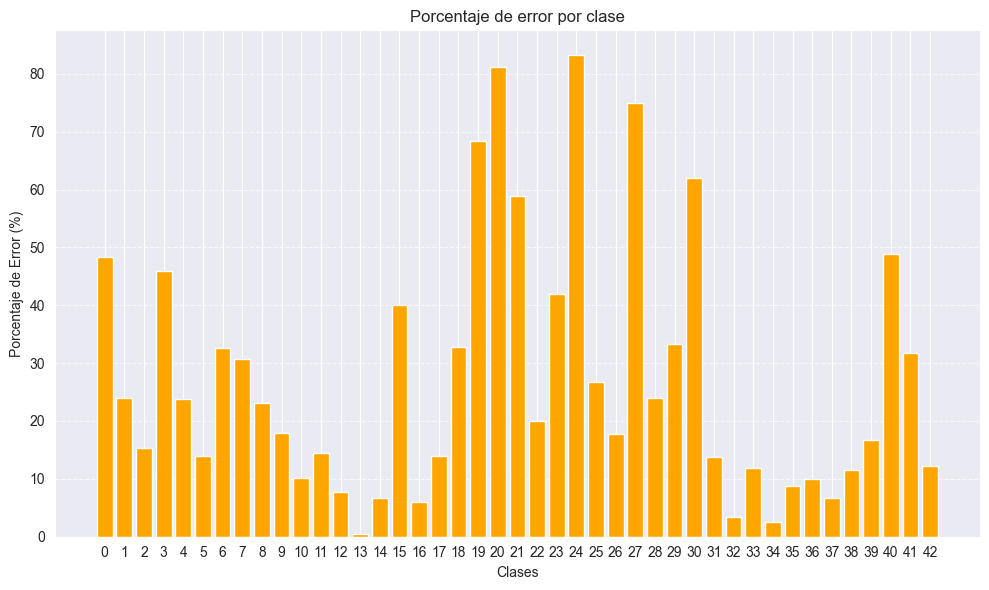

In [28]:
################ COMPLETAR #################

def plot_error_per_class(cm, title="Porcentaje de error por clase"):
    """
    Calcula y visualiza el porcentaje de error por clase a partir de la matriz de confusión.

    Args:
        cm (numpy.ndarray): Matriz de confusión (2D array).
        title (str): Título del gráfico.
    """
    # Calcular el porcentaje de error por clase
    accuracy_per_class = np.nan_to_num(cm.diagonal() / cm.sum(axis=1))
    error_per_class = 1 - accuracy_per_class   # COMPLETAR
    
    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(cm)), 100 * error_per_class, color='orange')
    plt.xlabel("Clases")
    plt.ylabel("Porcentaje de Error (%)")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(np.arange(len(cm)))
    plt.tight_layout()
    plt.show()
############## Fin COMPLETAR ###############

plot_error_per_class(cm)

Al observar tus resultados, podemos sacar estas conclusiones rápidas:

-Aciertos casi perfectos: La clase 13 (señal de "Ceda el paso") tiene prácticamente un 0% de error. Investigando un poco, esto se puede deber a que su forma de triángulo invertido y colores son únicos en el dataset.

- Puntos críticos: Las clases con barras más altas (como la 24, 27 y 30) tienen errores que superan el 40%. Estas se corresponden a  señales de advertencia triangulares que el MLP confunde entre sí porque todas tienen bordes rojos y fondos blancos muy parecidos.

- Rendimiento General: Aunque el accuracy global es del 88%, este gráfico demuestra que el error no se reparte igual: el modelo es bueno en algunas señales pero no tanto con las que tienen detalles internos pequeños.

## Guarda las funciones en un archivo llamado `utils.py`:

1. `count_trainable_params`
2. `train`
3. `evaluate`
4. `train_and_evaluate`
5. `save_full_model`
6. `load_full_model`
7. `plot_loss_accuracy`
8. `plot_confusion_matrix`
9. `plot_error_per_class`

## Guarda el modelo o modelos un archivo llamado `models.py`


---------------------